## 7.2 Preparing a dataset for supervised instruction fine-tuning


In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:  # 1
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)


data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
import pprint


pprint.pp(data[0])

{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}


Instruction fine-tuning involves training a model on datasets like the one above.

The way we do so is by training them on the text, structuring it into certain formats (called prompt styles).

## Apply Alpaca prompt style template
```
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Output:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".
```

## Apply Phi-3 prompt style template
```
<|user|>
Evaluate the following phrase by transforming it into the spelling given: "freind --> friend" 

<|assistant|>
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".
```


In [3]:
def format_input(entry):
    instruction_text = (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry["instruction"]}"
    )

    # In case there is no input, e.g. for instructions like "What is an antonym of 'complicated'?"
    input_text = f"\n\n### Input:\n{entry["input"]}" if entry["input"] else ""

    return instruction_text + input_text

In [4]:
model_input = format_input(data[0])
desired_response = f"\n\n### Response:\n{data[0]["output"]}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [5]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(f"Training set length: {len(train_data)}")
print(f"Validation set length: {len(val_data)}")
print(f"Test set length: {len(test_data)}")

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

In [6]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plut_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry["output"]}"
            full_text = instruction_plut_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [7]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [8]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [9]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for i, item in enumerate(batch):
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

custom_collate_fn([[1,2,3,4,5], [1,2,3]])

(tensor([[    1,     2,     3,     4,     5],
         [    1,     2,     3, 50256, 50256]]),
 tensor([[    2,     3,     4,     5, 50256],
         [    2,     3, 50256,  -100,  -100]]))

## 7.4 Creating data loaders for an instruction dataset

In [10]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024  # max context length supported by GPT-2
)

In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
   test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## 7.5 Loading a pretrained LLM

In [13]:
from build_a_large_language_model_from_scratch.gpt_download import download_and_load_gpt2
from build_a_large_language_model_from_scratch.lib.GPTModel import GPTModel
from build_a_large_language_model_from_scratch.lib.load_weights import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="gpt2"
)

model = GPTModel(
    context_length=BASE_CONFIG["context_length"],
    drop_rate=BASE_CONFIG["drop_rate"],
    emb_dim=BASE_CONFIG["emb_dim"],
    n_heads=BASE_CONFIG["n_heads"],
    n_layers=BASE_CONFIG["n_layers"],
    qkv_bias=BASE_CONFIG["qkv_bias"],
    vocab_size=BASE_CONFIG["vocab_size"]
)
load_weights_into_gpt(model, params)
model.eval();

2025-01-11 13:10:12.522718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736597412.689019   23436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736597412.716309   23436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 13:10:13.199968: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/355M/checkpoint
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/355M/encoder.json) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


Let's assess the model's existing capabilities.

In [14]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [15]:
from build_a_large_language_model_from_scratch.lib.generate import text_to_token_ids, token_ids_to_text, generate

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [16]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.6 Fine-tuning the LLM on instruction data


In [17]:
%load_ext autoreload
%autoreload 2

In [19]:
from build_a_large_language_model_from_scratch.lib.loss import calc_loss_loader
from build_a_large_language_model_from_scratch.lib.train import train_model_simple

model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

Training loss: 3.8646755695343016
Validation loss: 3.761934423446655


In [20]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
exec_time_m = (end_time - start_time) / 60
print(f"Training completed in {exec_time_m:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

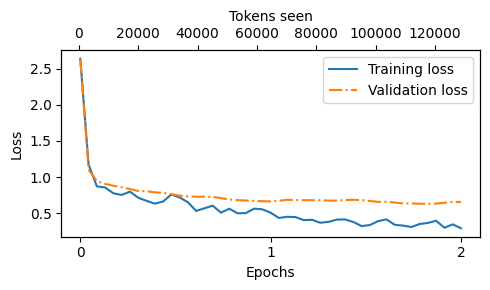

In [21]:
from build_a_large_language_model_from_scratch.lib.plot import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 Extracting and saving responses

In [22]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry["output"]}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-"*20)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
--------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
--------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
-----------